# U.S. Inaugural data
1. A list of 1 or more contextual datasets you have identified, links to where they reside, and a sentence about why they might be useful in telling the final story.

    All the transcription of U.S. inaugural speech are represented by natural language, which can be read by paragraphs, sentences or words. The data can be obtained from https://avalon.law.yale.edu/subject_menus/inaug.asp . I also plan to integrate google trends for these specific keywords.

2. One paragraph explaining how to use the dashboard you created, to help someone who is not an expert understand your dataset.

    I create a heatmap, where the rows are the presidents (represented by the presidency years), columns are the keywords in their speech. The values of the heatmap are the word frequency in their speech. If we select a cell on the heatmap, the dashboard will tell the word frequency of the selected cell, and the ranking of the presidents for this keyword.



In [2]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from collections import Counter

from nltk.corpus import inaugural
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import FreqDist

import ipywidgets
import bqplot
import pandas as pd

import pytrends

lemmatizer = WordNetLemmatizer()

%matplotlib inline

In [3]:
nltk.download('stopwords')
nltk.download('inaugural')
nltk.download('wordnet')

STOP = stopwords.words('english')


[nltk_data] Downloading package stopwords to /home/ran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package inaugural to /home/ran/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


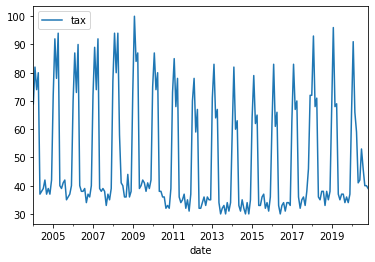

In [4]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ["tax"]
pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='US', gprop='')
df = pytrends.interest_over_time()
fig, ax = plt.subplots(1,1)
df.plot(ax=ax)
plt.show()

In [4]:
def get_pres_id():
    pres_list = inaugural.fileids()
    # name_set = set()
    last_name = None
    result = []
    for line in pres_list:
        year, n = line.rstrip(".txt").split("-")
        if n == last_name:
            last_name = n
            continue
        else:
            last_name = n
            result.append((year, n, line))
    return result
    
year = np.array([int(tri[0]) for tri in get_pres_id()])
year2name = {year: name for year, name, line in get_pres_id()}

In [5]:
kw_list = "justice,democracy,republic,tax,economy,patriotism,god,liberty,crime,wealth,poverty".split(',')
 
def to_kw2d(ids, kw_list):
    x = []
    y = []
    idx = []
    dic = {k: [] for k in kw_list}
    for year, name, fileid in ids:
        idx.append(name)
        words = [lemmatizer.lemmatize(w.lower()) for w in inaugural.words(fileid) if w.isalnum()]
        ctr = Counter(words)
        for k in kw_list:
            dic[k].append(ctr.get(k, 0))
    df = pd.DataFrame(dic, index=idx)
    return df

kw2d = to_kw2d(get_pres_id(),kw_list)

In [6]:
mySelectedLabel = ipywidgets.Label()
y_range = ipywidgets.IntRangeSlider(value=[30,40],
                        min=0,
                        max=len(get_pres_id()),
                        step=1,
                        description="Presidency",
                        disabled=False,
                        continuous_update=False,
                        orientation='horizontal',
                        readout=True)
def updateYAxis(change):
    #Update X-axis min/max value here
    if change['type'] == 'change' and change['name'] == 'value':
        y_sc.domain = year[change['new'][0]:change['new'][1]].tolist()
def on_selected(change): # building
    if len(change['owner'].selected) == 1:
        i, j = change['owner'].selected[0]
        v = np.array(kw2d)[i, j] # CHANGED THIS FOR 3D DATA!!!
        # mySelectedLabel.value = 'word frequency' + str(v)
        # pres_by_key = dict(kw2d[kw_list[j]].sort_values(ascending=False)[:4])
        idx = (-kw2d[kw_list[j]]).argsort()
        pres_by_key = dict(kw2d[kw_list[j]][idx][:4])
        # print(pres_by_key)
        bykey_str =  '\t'.join(k+'='+str(v) for k, v in pres_by_key.items())
        mySelectedLabel.value = 'Selected word frequency=' + str(v) + '. Top presidents of "' + kw_list[j] +'" are ' + bykey_str + ', in ' + ', '.join([str(year[i]) for i in idx][:4])+'.'
        # mySelectedLabel.value = str(kw2d[kw_list[j]][idx][:4])

year = np.array([int(tri[0]) for tri in get_pres_id()])

col_sc = bqplot.ColorScale(scheme="Blues") 

x_sc = bqplot.OrdinalScale()
y_sc = bqplot.OrdinalScale()
y_sc.domain = year[-10:].tolist()

# 3. Axis -- for colors, the axis is a colorbar!
ax_col = bqplot.ColorAxis(scale = col_sc, orientation='vertical', side='right') 
ax_x = bqplot.Axis(scale = x_sc,) # same x/y ax we had before
ax_y = bqplot.Axis(scale = y_sc, orientation='vertical')
# 4. Mark -- heatmap
heat_map = bqplot.GridHeatMap(color = kw2d, row=year,column=kw_list, scales = {'color':col_sc, 'row':y_sc, 'column':x_sc},
                            interactions={'click':'select'},
                            anchor_style={'fill':'blue'},
                            selected_style={'opacity':1.0},
                            unselected_style={'opacity':0.8})
# 5. Interactions -- going to be built into the GridHeatMap mark (how things *look* when selection happens)
# BUT I'm going to define what happens when the interaction takes place (something is selected)
heat_map.observe(on_selected, 'selected')
y_range.observe(updateYAxis)

fig = bqplot.Figure(marks = [heat_map], axes=[ax_col, ax_x, ax_y]) # have to add this axis 
ipywidgets.VBox([y_range,mySelectedLabel,fig])

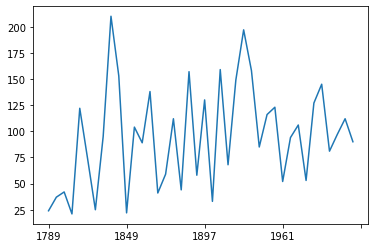

The longest speech is from Harrison, in 1841, containing 210 sentences.
The shortest speech is from Madison, in 1809, containing 21 sentences.


In [7]:
def count_sentence(ids):
    x = []
    y = []
    for year, name, fileid in ids:
        x.append(year)
        sent_cnt = len(inaugural.sents(fileid))
        y.append(sent_cnt)
    return x, y
ids = get_pres_id()
x, y = count_sentence(ids)
# print(len(x))
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.plot(x, y)
plt.show()

max_id = np.array(y).argmax()
min_id = np.array(y).argmin()
print("The longest speech is from %s, in %s, containing %d sentences." % (ids[max_id][1], ids[max_id][0], y[max_id]))
print("The shortest speech is from %s, in %s, containing %d sentences." % (ids[min_id][1], ids[min_id][0], y[min_id]))

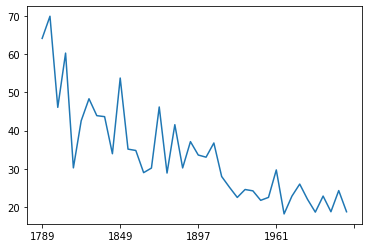

The longest average sentence is from Adams, in 1797, 69 words/sentence.
The shortest average sentence is from Johnson, in 1965, 18 words/sentence.


In [8]:
def count_avg_sent(ids):
    x = []
    y = []
    for year, name, fileid in ids:
        x.append(year)
        sent = inaugural.sents(fileid)
        lens = np.array([len(s) for s in sent]).mean()
        y.append(lens)
    return x, y
ids = get_pres_id()
x, y = count_avg_sent(ids)
# print(len(x))
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.plot(x, y)
plt.show()

max_id = np.array(y).argmax()
min_id = np.array(y).argmin()
print("The longest average sentence is from %s, in %s, %d words/sentence." % (ids[max_id][1], ids[max_id][0], y[max_id]))
print("The shortest average sentence is from %s, in %s, %d words/sentence." % (ids[min_id][1], ids[min_id][0], y[min_id]))

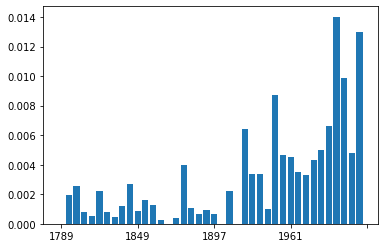

In [9]:
def keywords(ids):
    x = []
    y = []
    keyw = 'america,democracy,freedom,protection'.split(',')
    for year, name, fileid in ids:
        
        words = [lemmatizer.lemmatize(w.lower()) for w in inaugural.words(fileid) if w.isalnum()]
        ctr = Counter(words)
        
        cnt = sum([ctr[i] for i in keyw])
        all_words = len(inaugural.words(fileid))
        ratio = cnt/all_words
        
        x.append(year)
        y.append(ratio)
    return x, y
ids = get_pres_id()
x, y = keywords(ids)
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax.bar(x, y)
plt.show()